In [123]:
# get the work directory
import os
os.getcwd()
#os.chdir('/content/sample_data')  #change the work directory

In [2]:
with open("C:\\Users\\User\\Desktop\\Hackathon\\camp_dataset\\sim_question_train.txt", encoding = "utf-8") as f:
    dat_train = f.readlines()

In [3]:
with open("C:\\Users\\User\\Desktop\\Hackathon\\camp_dataset\\sim_question_test.txt", encoding = "utf-8") as f:
    dat_test = f.readlines()

In [4]:
# import module
import numpy as np
import pandas as pd
import jieba
import gensim
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import models

In [5]:
from time import time
import itertools
import datetime

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [6]:
## define the function that split the data
def split_train_data (text):
    text_pd = pd.DataFrame(text)
    text_pd.columns = ["question"]
    question = text_pd["question"].str.split("@@@@@", expand = True)
    text_pd["q1"] = question[0]
    text_pd["q2"] = question[1]
    text_pd["pair"] = question[2]
    text_pd.drop("question", axis = 1, inplace =True)
    return text_pd

def split_test_data (text):
    text_pd = pd.DataFrame(text)
    text_pd.columns = ["question"]
    question = text_pd["question"].str.split("@@@@@", expand = True)
    text_pd["q1"] = question[0]
    text_pd["q2"] = question[1]
    text_pd.drop("question", axis = 1, inplace =True)
    return text_pd

In [7]:
data_train = split_train_data(dat_train)
data_test = split_test_data(dat_test)

In [8]:
# first remove the \n in the train pair column
data_train["pair"] = data_train["pair"].replace(r"\n", "",regex = True)
data_train["pair"] = data_train["pair"].str.strip()

In [9]:
# define the function to clean data
def clean_data (data):
    # remove the meaningless signs
    for column in data:
        # remove $
        data[column] = data[column].str.replace("$", "")  
        
        #remove the numbers, the alphabets
        #data[column] = data[column].str.replace("\d+", "").str.replace(r'[A-Za-z]+', '') 
        
        # remove the calculation sign (like +, -, *, (, { )
        data[column] = data[column].apply(lambda x: x.replace("+", "").replace("-", "").replace("=", "").replace("*", ""))
        data[column] = data[column].apply(lambda x: x.replace("{","").replace("}","").replace("、","").replace("：","").replace("？","").replace("（","").replace("）","").replace("，","").replace(".",""))
        data[column] = data[column].apply(lambda x: x.replace("(","").replace(")","").replace("?","").replace("。","").replace("|","").replace(",","").replace("^","").replace("；",""))
        
        # remove the white space and \xa0 within sentences
        data[column] = data[column].str.replace(" ", "").str.replace(u'\xa0', "")
        
        # remove white spaces
        data[column] = data[column].str.strip() 
        
    return data

In [10]:
# clean dataset
data_train = clean_data(data_train)
data_test = clean_data(data_test)
#data_train.head(500)

In [11]:
## define tokenize function
def tokenize_question (data, column):
    q_words = []
    for i in data[column]:
        segs = jieba.cut(i)
        result = " ".join(segs).split(" ")
        q_words.append(result)
    return q_words

In [12]:
# tokenize the train and test data
q1_words = tokenize_question(data_train, "q1")
q2_words = tokenize_question(data_train,"q2")
q1_test_words = tokenize_question(data_test, "q1")
q2_test_words = tokenize_question(data_test, "q2")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 1.246 seconds.
Prefix dict has been built successfully.


In [13]:
words_combine = []
vic = dict()
for i in q1_words:
    words_combine.append(i)
for i in q2_words:
    words_combine.append(i)
for i in q1_test_words:
    words_combine.append(i)
for i in q2_test_words:
    words_combine.append(i)

In [14]:
len(words_combine)

40572

In [15]:
## use model to train word embedding
#model1 = gensim.models.Word2Vec(words_combine, size=100, window=5, min_count=1)    ## accuracy = 0.690
#model2 = gensim.models.Word2Vec(words_combine, size=200, window=5, min_count=1)     ## accuracy = 0.688
#model3 = gensim.models.Word2Vec(words_combine, size=150, window=5, min_count=1)      ## accuracy = 0.6878
#model4 = gensim.models.Word2Vec(words_combine, size=100, window=8, min_count=1)    ## accuracy = 0.708
#model5 = gensim.models.Word2Vec(words_combine, size=100, window=10, min_count=1)    ## accuracy = 0.711
#model6 = gensim.models.Word2Vec(words_combine, size=100, window=12, min_count=1)    ## accuracy = 0.716
model7 = gensim.models.Word2Vec(words_combine, size=300, window=8, min_count=1)    ## accuracy = 0.7066

In [16]:
## define tokenize function
def tokenize_question_sec (data):
    segs = jieba.cut(data)
    result = " ".join(segs).split(" ")
    return result

In [17]:
from gensim.test.utils import datapath
# prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
#word2vec = KeyedVectors.load_word2vec_format(datapath("euclidean_vectors.bin"), binary=True)
questions_cols = ['q1', 'q2']

In [18]:
# Iterate over the questions only of both training and test datasets
for dataset in [data_train, data_test]:
    for index, row in dataset.iterrows():
        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in tokenize_question_sec(row[question]):

                # Check for unwanted words
                #if word in stops and word not in word2vec.vocab:
                #    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.loc[index, question] = q2n

In [19]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
        embeddings[index] = model7[word]

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [20]:
from itertools import product
# prepare training and validation data
max_seq_length = max(data_train.q1.map(lambda x: len(x)).max(),
                     data_train.q2.map(lambda x: len(x)).max(),
                     data_test.q1.map(lambda x: len(x)).max(),
                     data_test.q2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 4000
training_size = len(data_train) - validation_size

X = data_train[questions_cols]
Y = data_train['pair']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.q1, 'right': X_train.q2}
X_validation = {'left': X_validation.q1, 'right': X_validation.q2}
X_test = {'left': data_test.q1, 'right': data_test.q2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [23]:
# build the model
# Model variables
n_hidden = 30  ## the number of hidden layers 
gradient_clipping_norm = 1.25   
batch_size = 64  ## the number of training examples each batch
n_epoch = 20

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 14018 samples, validate on 4000 samples
Epoch 1/20
14018/14018 [==============================] - 297s 21ms/step - loss: 0.2875 - accuracy: 0.5794 - val_loss: 0.2485 - val_accuracy: 0.5810
Epoch 2/20
14018/14018 [==============================] - 303s 22ms/step - loss: 0.2083 - accuracy: 0.6679 - val_loss: 0.2045 - val_accuracy: 0.6718
Epoch 3/20
14018/14018 [==============================] - 314s 22ms/step - loss: 0.1907 - accuracy: 0.7131 - val_loss: 0.1944 - val_accuracy: 0.6960
Epoch 4/20
14018/14018 [==============================] - 308s 22ms/step - loss: 0.1838 - accuracy: 0.7278 - val_loss: 0.1880 - val_accuracy: 0.7197
Epoch 5/20
14018/14018 [==============================] - 322s 23ms/step - loss: 0.1790 - accuracy: 0.7440 - val_loss: 0.1856 - val_accuracy: 0.7207
Epoch 6/20
14018/14018 [==============================] - 319s 23ms/step - loss: 0.1754 - accuracy: 0.7468 - val_loss: 0.1806 - val_accuracy: 0.7368
Epoch 7/20
14018/14018 [==============================] -

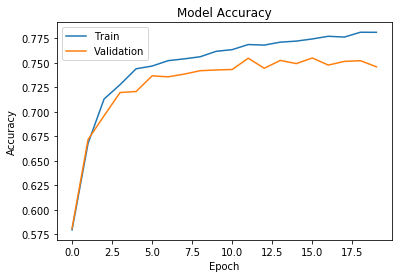

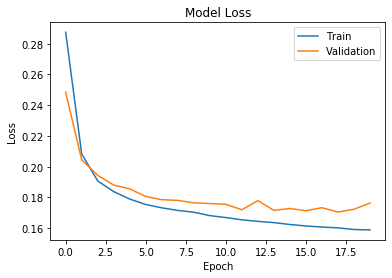

In [28]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()